In [1]:
import numpy as np
import scipy.io as sio
import os
import time
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
import keras
from keras.layers import Dropout, Input, Conv2D, Conv3D, MaxPool3D, Flatten, Dense, Reshape, BatchNormalization
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

#load your data here

In [4]:
Indian_pine_data = sio.loadmat(os.path.join("G:\AA_GANN_data\Indian_pines_corrected.mat"))['indian_pines_corrected']
Indian_pine_label = sio.loadmat(os.path.join("G:\AA_GANN_data\Indian_pines_gt.mat"))['indian_pines_gt']

In [5]:
y_label = Indian_pine_label.ravel()
zero = [i for i in range(len(y_label)) if y_label[i]==0]

# INDIAN PINE HYPERSPECTRAL IMAGE

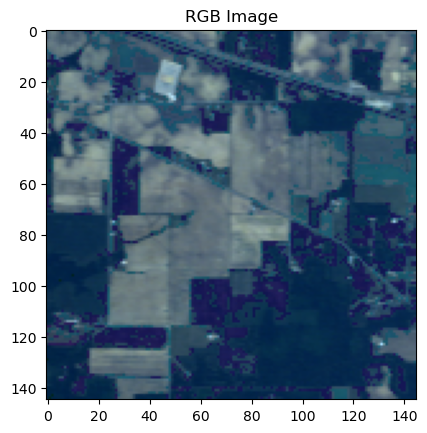

In [6]:
# Choose three bands for RGB display
band1 = 29  # Choose band 29
band2 = 19  # Choose band 19
band3 = 9  # Choose band 9

# Extract the selected bands from the image data
image_rgb = np.stack((Indian_pine_data[:, :, band1], Indian_pine_data[:, :, band2], Indian_pine_data[:, :, band3]), axis=-1)

# # Normalize the RGB image data to [0, 255]
image_rgb = (image_rgb - np.min(image_rgb)) / (np.max(image_rgb) - np.min(image_rgb)) * 255
image_rgb = image_rgb.astype(np.uint8)

# Display the RGB image
plt.imshow(image_rgb)
plt.title('RGB Image')
plt.show()

In [7]:
## Dimensional Reduction Method
def reduce_dimensions(data, num_components = 75):
    reshaped_data = np.reshape(data, (-1, data.shape[2]))
    n_batches = 256
    inc_pca = IncrementalPCA(n_components=num_components)
    for batch in np.array_split(reshaped_data, n_batches):
        inc_pca.partial_fit(batch)
    transformed_data = inc_pca.transform(reshaped_data)
    reduced_data = np.reshape(transformed_data, (data.shape[0], data.shape[1], num_components))
    return reduced_data

In [8]:
## Padding
def zero_pad(data, margin=2):
    padded_data = np.zeros((data.shape[0] + 2 * margin, data.shape[1] + 2 * margin, data.shape[2]))
    x_offset = margin
    y_offset = margin
    padded_data[x_offset:data.shape[0] + x_offset, y_offset:data.shape[1] + y_offset, :] = data
    return padded_data


In [9]:
## Spatial Patches in 3D
def extract_cubes(data, ground_truth, window_size=5, remove_zero_labels=True):
    margin = int((window_size - 1) / 2)
    zero_padded_data = zero_pad(data, margin=margin)
    # split patches
    patches_data = np.zeros((data.shape[0] * data.shape[1], window_size, window_size, data.shape[2]))
    patches_labels = np.zeros((data.shape[0] * data.shape[1]))
    patch_index = 0
    for r in range(margin, zero_padded_data.shape[0] - margin):
        for c in range(margin, zero_padded_data.shape[1] - margin):
            patch = zero_padded_data[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patches_data[patch_index, :, :, :] = patch
            patches_labels[patch_index] = ground_truth[r - margin, c - margin]
            patch_index = patch_index + 1
    if remove_zero_labels:
        patches_data = patches_data[patches_labels > 0,:,:,:]
        patches_labels = patches_labels[patches_labels > 0]
        patches_labels -= 1
    return patches_data, patches_labels


# DATA PREPARATION

In [10]:
Indian_pine_data.shape, Indian_pine_label.shape

((145, 145, 200), (145, 145))

In [11]:
## Reduce the Dimensionality 
data = reduce_dimensions(Indian_pine_data, num_components=20)
data.shape

(145, 145, 20)

In [12]:
x_data, ylb = extract_cubes(data, Indian_pine_label, window_size=11, remove_zero_labels=False)

In [13]:
x_total = x_data.reshape(-1, 11, 11, 20, 1)

In [14]:
data, label = extract_cubes(data, Indian_pine_label, window_size=11)
data.shape, label.shape

((10249, 11, 11, 20), (10249,))

split data into training and testing

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.4, random_state=345, stratify=label)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6149, 11, 11, 20), (4100, 11, 11, 20), (6149,), (4100,))

split training data to train and validation

In [16]:
x_tra, x_veli, y_tra, y_veli =  train_test_split(x_train, y_train, test_size=0.3, random_state=345)
x_tra.shape, x_veli.shape, y_tra.shape, y_veli.shape

((4304, 11, 11, 20), (1845, 11, 11, 20), (4304,), (1845,))

In [17]:
#reshape data
x_tra = x_tra.reshape(-1, 11, 11, 20, 1)
y_tra = np_utils.to_categorical(y_tra)
x_veli = x_veli.reshape(-1, 11, 11, 20, 1) 
y_veli = np_utils.to_categorical(y_veli)
x_tra.shape, y_tra.shape, x_veli.shape, y_veli.shape

((4304, 11, 11, 20, 1), (4304, 16), (1845, 11, 11, 20, 1), (1845, 16))

# CNN IMPLEMENTATION

In [18]:
# Input layer
input_layer = Input((11, 11, 20, 1))

In [19]:
# 3d convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)

In [20]:
# Faltten 
flatten_layer = Flatten()(conv_layer4)

In [21]:
## Fully Connected Layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=16, activation='softmax')(dense_layer2)

In [22]:
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11, 11, 20, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 9, 9, 14, 8)       512       
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 7, 10, 16)      5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 5, 5, 8, 32)       13856     
                                                                 
 conv3d_3 (Conv3D)           (None, 3, 3, 6, 64)       55360     
                                                                 
 flatten (Flatten)           (None, 3456)              0         
                                                                 
 dense (Dense)               (None, 256)               884992

In [23]:
# compiling the model
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [24]:
start = time.time()
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
history = model.fit(x=x_tra, y=y_tra, batch_size=128,callbacks=[es_callback], epochs=50, validation_data=(x_veli, y_veli))
end = time.time()
Tr_Time = end - start

Epoch 1/50
34/34 [==============================] - 16s 411ms/step - loss: 5.5304 - accuracy: 0.2279 - val_loss: 1.7058 - val_accuracy: 0.4867
Epoch 2/50
34/34 [==============================] - 12s 368ms/step - loss: 1.5713 - accuracy: 0.4902 - val_loss: 1.1510 - val_accuracy: 0.6211
Epoch 3/50
34/34 [==============================] - 11s 336ms/step - loss: 1.1661 - accuracy: 0.5987 - val_loss: 0.8821 - val_accuracy: 0.6986
Epoch 4/50
34/34 [==============================] - 12s 352ms/step - loss: 0.9170 - accuracy: 0.6856 - val_loss: 0.6787 - val_accuracy: 0.7561
Epoch 5/50
34/34 [==============================] - 11s 334ms/step - loss: 0.7069 - accuracy: 0.7472 - val_loss: 0.4950 - val_accuracy: 0.8298
Epoch 6/50
34/34 [==============================] - 11s 330ms/step - loss: 0.5583 - accuracy: 0.8088 - val_loss: 0.4311 - val_accuracy: 0.8558
Epoch 7/50
34/34 [==============================] - 11s 330ms/step - loss: 0.4452 - accuracy: 0.8525 - val_loss: 0.3527 - val_accuracy: 0.8873

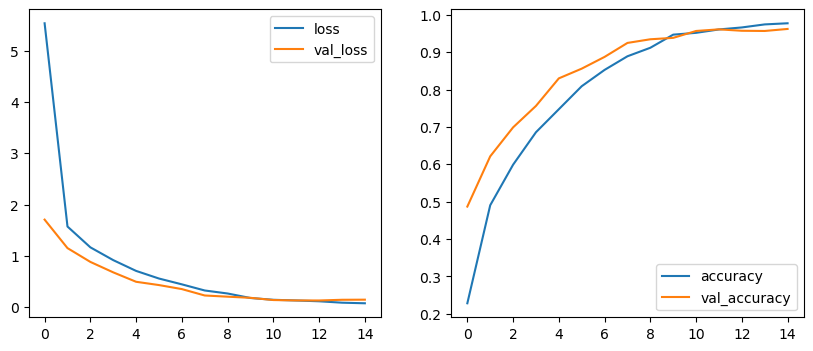

In [25]:
import pandas as pd
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [26]:
## Testing Phase
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
## Reshape Test Data
x_test = x_test.reshape(-1, 11, 11, 20, 1)
y_test = np_utils.to_categorical(y_test)
x_test.shape, y_test.shape

((4100, 11, 11, 20, 1), (4100, 16))

In [27]:
start = time.time()
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
end = time.time()
total = end - start
target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn','Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill','Soybean-clean', 'Wheat', 'Woods', 
                'Buildings-Grass-Trees-Drives','Stone-Steel-Towers']
classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
print(classification)

129/129 [==============================] - 4s 30ms/step
                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.89      0.94        19
                 Corn-notill       0.93      0.96      0.95       571
                Corn-mintill       0.95      0.95      0.95       332
                        Corn       0.99      0.79      0.88        95
               Grass-pasture       0.99      0.97      0.98       193
                 Grass-trees       0.94      1.00      0.97       292
         Grass-pasture-mowed       1.00      0.64      0.78        11
               Hay-windrowed       0.95      1.00      0.98       191
                        Oats       1.00      0.88      0.93         8
              Soybean-notill       0.95      0.94      0.95       389
             Soybean-mintill       0.98      0.97      0.97       982
               Soybean-clean       0.92      0.93      0.93       237
                       Wheat     

In [28]:
score = model.evaluate(x_test, y_test, batch_size=32)
Test_Loss =  score[0]*100
Test_accuracy = score[1]*100

print("test loss = ",  Test_Loss)
print("test accuracy = " , Test_accuracy)

129/129 [==============================] - 4s 30ms/step - loss: 0.1385 - accuracy: 0.9617
test loss =  13.851173222064972
test accuracy =  96.17072939872742


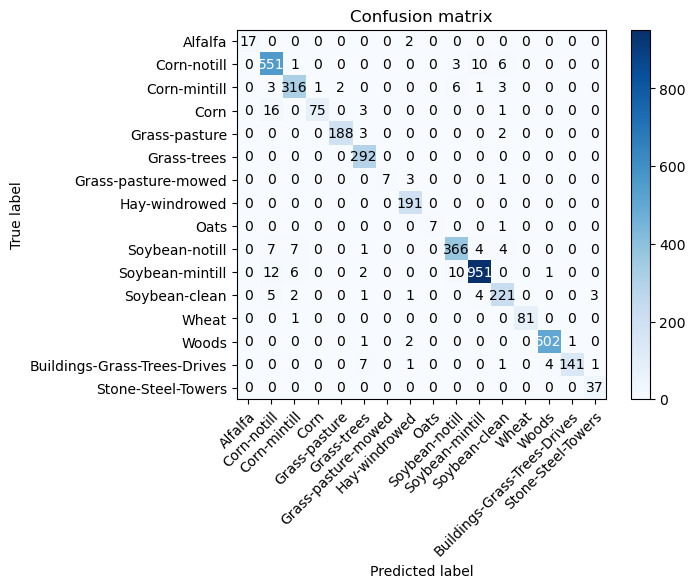

In [29]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Create the figure and axis
fig, ax = plt.subplots()

# Create the heatmap
im = ax.imshow(cm, cmap='Blues')

# Add the colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the axis labels
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=target_names,
       yticklabels=target_names,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over the data and add the text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Set the title
ax.set_title("Confusion matrix")

# Show the figure
plt.show()


In [30]:
label_pred = model.predict(x_total)
label_pred = np.argmax(label_pred, axis=1)
label_pred += 1

658/658 [==============================] - 21s 31ms/step


In [31]:
for i in zero:
    label_pred[i]=0
y_pred_total=np.array(label_pred).reshape(Indian_pine_label.shape[0],Indian_pine_label.shape[1])

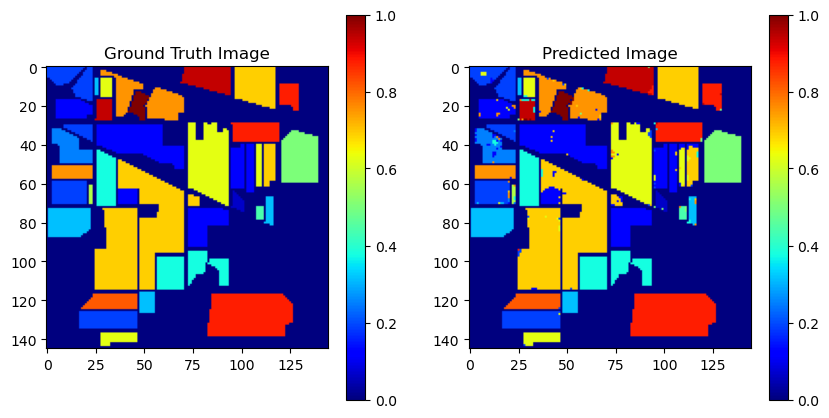

In [32]:
# Visualization of Result
# Normalize
y_norm = (Indian_pine_label - Indian_pine_label.min()) / (Indian_pine_label.max() - Indian_pine_label.min())
outputs_norm = (y_pred_total - y_pred_total.min()) / (y_pred_total.max() - y_pred_total.min())

# Create a colormap
cmap = plt.cm.jet

# Apply the colormap and normalization to create ScalarMappable objects
import matplotlib
y_mappable = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=y_norm.min(), vmax=y_norm.max()), cmap=cmap)
outputs_mappable = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=outputs_norm.min(), vmax=outputs_norm.max()), cmap=cmap)

# Create subplots for displaying both images side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Display actual image
axes[0].imshow(y_mappable.to_rgba(y_norm))
axes[0].set_title("Ground Truth Image")

# Display predicted image
axes[1].imshow(outputs_mappable.to_rgba(outputs_norm))
axes[1].set_title('Predicted Image')

# Add colorbars
fig.colorbar(y_mappable, ax=axes[0])
fig.colorbar(outputs_mappable, ax=axes[1])
plt.show()

# IMPLEMENTATION OF SVM

In [33]:
from sklearn.multiclass import OneVsOneClassifier

In [34]:
data1 = Indian_pine_data
label1 = Indian_pine_label

In [35]:
# reshape data
X= data1.reshape((-1, data1.shape[2]))
y = label1.ravel()

In [36]:
# Remove classes with no samples
X = X[y > 0, :]
y = y[y > 0] - 1


In [37]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [38]:
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reduce dimensionality using PCA
pca = PCA(n_components=50)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [39]:
# Train SVM
svm = SVC(kernel='rbf', C=50, gamma='auto', random_state=42)
svm_model = OneVsOneClassifier(svm).fit(X_train, y_train)

In [40]:
# Predict labels for test set
y_pred = svm_model.predict(X_test)

In [41]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of svm: {accuracy}")

Accuracy of svm: 0.8822764227642277


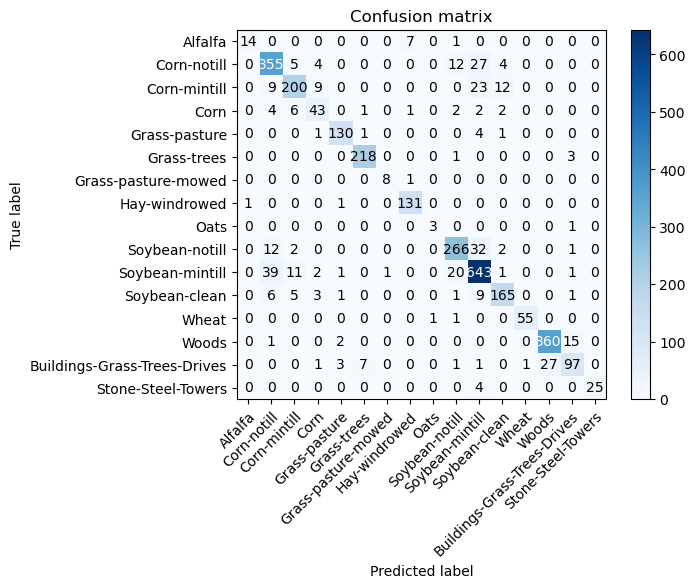

In [42]:
# Calculate confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

# Create the figure and axis
fig, ax = plt.subplots()

# Create the heatmap
im = ax.imshow(confusion_matrix, cmap='Blues')

# Add the colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the axis labels
ax.set(xticks=np.arange(confusion_matrix.shape[1]),
       yticks=np.arange(confusion_matrix.shape[0]),
       xticklabels=target_names,
       yticklabels=target_names,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over the data and add the text annotations
thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, format(confusion_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

# Set the title
ax.set_title("Confusion matrix")

# Show the figure
plt.show()

In [43]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.64      0.76        22
           1       0.83      0.87      0.85       407
           2       0.87      0.79      0.83       253
           3       0.68      0.70      0.69        61
           4       0.94      0.95      0.95       137
           5       0.96      0.98      0.97       222
           6       0.89      0.89      0.89         9
           7       0.94      0.98      0.96       133
           8       0.75      0.75      0.75         4
           9       0.87      0.84      0.86       315
          10       0.86      0.89      0.88       719
          11       0.88      0.86      0.87       191
          12       0.98      0.96      0.97        57
          13       0.93      0.95      0.94       378
          14       0.82      0.70      0.75       138
          15       1.00      0.86      0.93        29

    accuracy                           0.88      3075
   macro avg       0.88   

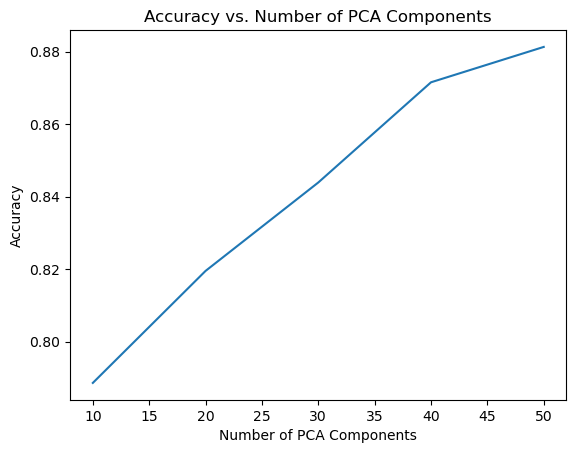

In [44]:
# Plot accuracy over number of PCA components
components = [10, 20, 30, 40, 50]
accuracies = []
for n in components:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    svm.fit(X_train_pca, y_train)
    y_pred = svm.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

plt.plot(components, accuracies)
plt.title("Accuracy vs. Number of PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("Accuracy")
plt.show()


In [45]:
data = scaler.transform(data1.reshape((-1, data1.shape[2])))

# Reduce dimensionality using PCA
pca = PCA(n_components=50)
data = pca.fit_transform(data)
y_pred = svm_model.predict(data)


In [46]:
for i in zero:
    y_pred[i]=0
y_pred_total=np.array(y_pred).reshape(Indian_pine_label.shape[0],Indian_pine_label.shape[1])

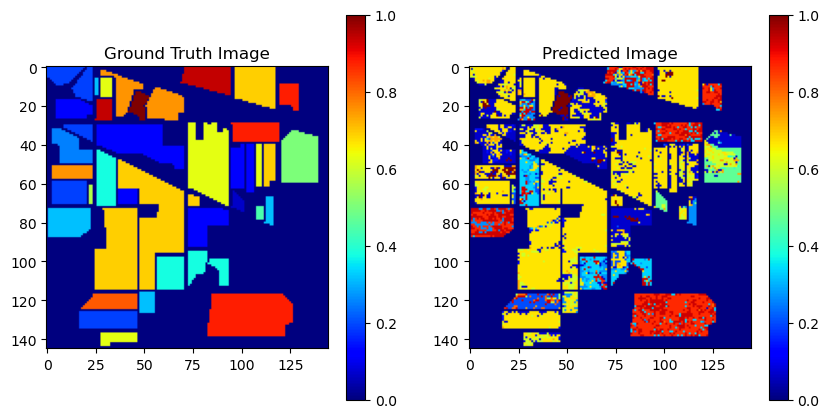

In [47]:
# Visualization of Result
# Normalize
y_norm = (Indian_pine_label - Indian_pine_label.min()) / (Indian_pine_label.max() - Indian_pine_label.min())
outputs_norm = (y_pred_total - y_pred_total.min()) / (y_pred_total.max() - y_pred_total.min())

# Create a colormap
cmap = plt.cm.jet

# Apply the colormap and normalization to create ScalarMappable objects
import matplotlib
y_mappable = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=y_norm.min(), vmax=y_norm.max()), cmap=cmap)
outputs_mappable = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=outputs_norm.min(), vmax=outputs_norm.max()), cmap=cmap)

# Create subplots for displaying both images side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Display actual image
axes[0].imshow(y_mappable.to_rgba(y_norm))
axes[0].set_title("Ground Truth Image")

# Display predicted image
axes[1].imshow(outputs_mappable.to_rgba(outputs_norm))
axes[1].set_title('Predicted Image')

# Add colorbars
fig.colorbar(y_mappable, ax=axes[0])
fig.colorbar(outputs_mappable, ax=axes[1])
plt.show()